In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(32)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.16:58441 Dashboard: http://10.148.1.16:8787/status,Cluster Workers: 64 Cores: 256 Memory: 3200.00 GB


---


# 1. Drifter 
#### $KE = u^2 + v^2$

In [35]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/'
drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     126303*1
# mlon2: mean longitude over 60 days,    126303*1

# qd: drogued drifters,                  126303*1
# qmed200: median water depth > 200 m,   126303*1
# qu: undrogued drifters,                126303*1

# uv2: (u, v),                           126303*1440

[('mlat2', <HDF5 dataset "mlat2": shape (126303, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (126303, 1), type "<f8">),
 ('qd', <HDF5 dataset "qd": shape (126303, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (126303, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (126303, 1), type "|u1">),
 ('uv2', <HDF5 dataset "uv2": shape (126303, 1440), type "|V16">)]

In [36]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 126303)>
array([ 39.51519 ,  39.682915,  40.437454, ..., -60.776903,  32.794351,
        27.131247])
Dimensions without coordinates: lat

In [37]:
# turn mean-lat into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 126303)>
array([150.087397, 151.958754, 152.837519, ..., 224.863612, 284.83327 ,
       285.592734])
Dimensions without coordinates: lon

In [38]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 126303)>
array([0, 0, 0, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [39]:
# turn undrogued_information into xarray_DataArray
qu = drifter_dataset['qu']
qu = np.array(qu)
qu = xr.DataArray(qu, dims=['qu', 'none'])
qu = xr.DataArray.squeeze(qu, dim='none')
qu = np.real(qu).rename('qu')
qu

<xarray.DataArray 'qu' (qu: 126303)>
array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)
Dimensions without coordinates: qu

In [40]:
qmed200 = drifter_dataset['qmed200']
qmed200 = np.array(qmed200)
qmed200 = xr.DataArray(qmed200, dims=['qmed200', 'none'])
qmed200 = xr.DataArray.squeeze(qmed200, dim='none')
qmed200 = np.real(qmed200).rename('qmed200')
qmed200

<xarray.DataArray 'qmed200' (qmed200: 126303)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qmed200

In [41]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((126303, 1440, 2))
u_drifters = uv[:,:,0] 
v_drifters = uv[:,:,1]

In [42]:
KE_drifters = (u_drifters**2 + v_drifters**2)

In [43]:
# Drifter Dataset (u+iv,lat,qd,time)
ds = xr.Dataset({'KE_drifters': (['lat', 'time'], KE_drifters)},
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd),
                         'qu':(['lat'],qu),
                         'qmed200':(['lat'],qmed200)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 126303, time: 1440)
Coordinates:
  * lat          (lat) float64 39.52 39.68 40.44 32.82 33.22 33.98 35.36 ...
    lon          (lat) float64 150.1 152.0 152.8 149.4 151.9 155.7 163.3 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 ...
    qu           (lat) uint8 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 ...
    qmed200      (lat) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Data variables:
    KE_drifters  (lat, time) float64 0.1058 0.1037 0.09827 0.05973 0.06012 ...

 data size: 1.5 GB


In [44]:
KE_drifters_qd = ds.KE_drifters.where((ds.qd==1) & (ds.qmed200==1)).mean(dim=['time'])
KE_drifters_qd = np.real(KE_drifters_qd).rename('KE_drifters_qd')

KE_drifters_qu = ds.KE_drifters.where((ds.qu==1) & (ds.qmed200==1)).mean(dim=['time'])
KE_drifters_qu = np.real(KE_drifters_qu).rename('KE_drifters_qu')

KE_drifters_all = ds.KE_drifters.where(ds.qmed200==1).mean(dim=['time'])
KE_drifters_all = np.real(KE_drifters_all).rename('KE_drifters_all')

In [45]:
E_drifters_qd = KE_drifters_qd.groupby_bins(KE_drifters_qd.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qd = E_drifters_qd.load()

E_drifters_qu = KE_drifters_qu.groupby_bins(KE_drifters_qu.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qu = E_drifters_qu.load()

E_drifters_all = KE_drifters_all.groupby_bins(KE_drifters_all.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_all = E_drifters_all.load()

Text(0.5,1,'Drifters')

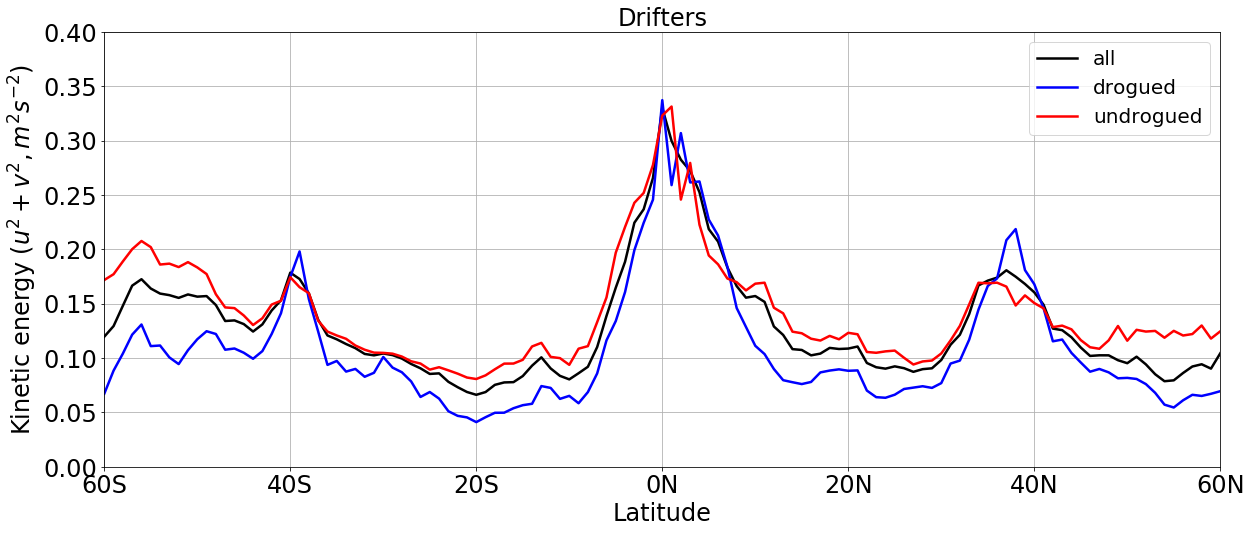

In [46]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['drogued', 'undrogued', 'all']

E_drifters_all.plot(color='black', label=labels[2], linewidth=2.5)
E_drifters_qd.plot(color='blue', label=labels[0], linewidth=2.5)
E_drifters_qu.plot(color='red', label=labels[1], linewidth=2.5)

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

# 2. LLC4320

In [14]:
## data files (SSU,SSV) ##
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC1080/'
KE_dir = '/home1/datawork/xyu/LLC4320/KE/'
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [17]:
# grid file
mgrid = xr.open_dataset('/home1/scratch/xyu/grid/mit_grid_t_1080.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','dxG','dyG','dxC','dyC','rAw','rAs','rAz','XC','CS','SN','rA'])
print(mgrid)

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    YC       (face, i, j) float32 ...
    Depth    (face, i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


In [18]:
## Here we do DFT on u+iv ##
time_chunk = 1440
ij_chunk = 108

for face in face_all:
    
    # Grid #
    grid = mgrid.isel(face=face)
    
    # Read SSU #
    ds_SSU = xr.open_zarr(data_dir+'SSU_f%02d.zarr'%(face)).rename({'i_g': 'i'})
    chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (2 months)
    ds_SSU = ds_SSU.chunk(chunks) 
    # Read SSV #
    ds_SSV = xr.open_zarr(data_dir+'SSV_f%02d.zarr'%(face)).rename({'j_g': 'j'})
    chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (2 months)
    ds_SSV = ds_SSV.chunk(chunks) 
    # Merge into one xarray dataset #
    ds = xr.merge([ds_SSU, ds_SSV, grid])    
    
    # u+iv
    KE_LLC = ds.SSU**2 + ds.SSV**2    # KE
    KE_LLC_tmean = KE_LLC.mean(dim=['time']) 
    KE_LLC_tmean = np.real(KE_LLC_tmean).rename('KE_LLC_tmean')
    KE_LLC_tmean = xr.merge([KE_LLC_tmean, grid])
    file_E = KE_dir+'KE_LLC_tmean_f%02d_1080.zarr'%face
    %time KE_LLC_tmean.to_zarr(file_E, mode='w')  
    print('face %d done'%face )

CPU times: user 40.5 s, sys: 1.83 s, total: 42.4 s
Wall time: 44.1 s
face 0 done
CPU times: user 1min, sys: 2.48 s, total: 1min 2s
Wall time: 1min 13s
face 1 done
CPU times: user 52.2 s, sys: 2.24 s, total: 54.4 s
Wall time: 1min
face 2 done
CPU times: user 34.4 s, sys: 1.34 s, total: 35.8 s
Wall time: 36 s
face 3 done
CPU times: user 1min 6s, sys: 2.6 s, total: 1min 9s
Wall time: 1min 26s
face 4 done
CPU times: user 30.9 s, sys: 648 ms, total: 31.6 s
Wall time: 31.8 s
face 5 done
CPU times: user 1min 3s, sys: 2.41 s, total: 1min 5s
Wall time: 1min 20s
face 6 done
CPU times: user 1min 7s, sys: 2.21 s, total: 1min 9s
Wall time: 1min 29s
face 7 done
CPU times: user 1min 8s, sys: 2.47 s, total: 1min 11s
Wall time: 1min 30s
face 8 done
CPU times: user 46.9 s, sys: 1.48 s, total: 48.4 s
Wall time: 51.4 s
face 9 done
CPU times: user 47.3 s, sys: 1.69 s, total: 49 s
Wall time: 52.3 s
face 10 done
CPU times: user 1min 7s, sys: 2.34 s, total: 1min 9s
Wall time: 1min 27s
face 11 done
CPU times: 

In [19]:
D = [xr.open_zarr(KE_dir+'KE_LLC_tmean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:       (face: 13, i: 1080, j: 1080)
Coordinates:
  * i             (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 ...
  * j             (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 ...
    Depth         (face, i, j) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 270, 540)>
    YC            (face, i, j) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 270, 540)>
  * face          (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    KE_LLC_tmean  (face, j, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 108, 108)>

 data size: 0.2 GB


In [31]:
KE_LLC_mean = ds.KE_LLC_tmean

KE_LLC_zmean_openocean_1080 = (KE_LLC_mean.where(KE_LLC_mean.Depth>500).groupby_bins(KE_LLC_mean['YC'], np.arange(-59.5, 62, 1), labels=np.arange(-60, 61, 1))).mean()
KE_LLC_zmean_coastalocean_1080 = (KE_LLC_mean.where(KE_LLC_mean.Depth<500).groupby_bins(KE_LLC_mean['YC'], np.arange(-59.5, 62, 1), labels=np.arange(-60, 61, 1))).mean()
KE_LLC_zmean_all_1080 = (KE_LLC_mean.groupby_bins(KE_LLC_mean['YC'], np.arange(-59.5, 62, 1), labels=np.arange(-60, 61, 1))).mean()

Text(0.5,1,'LLC4320')

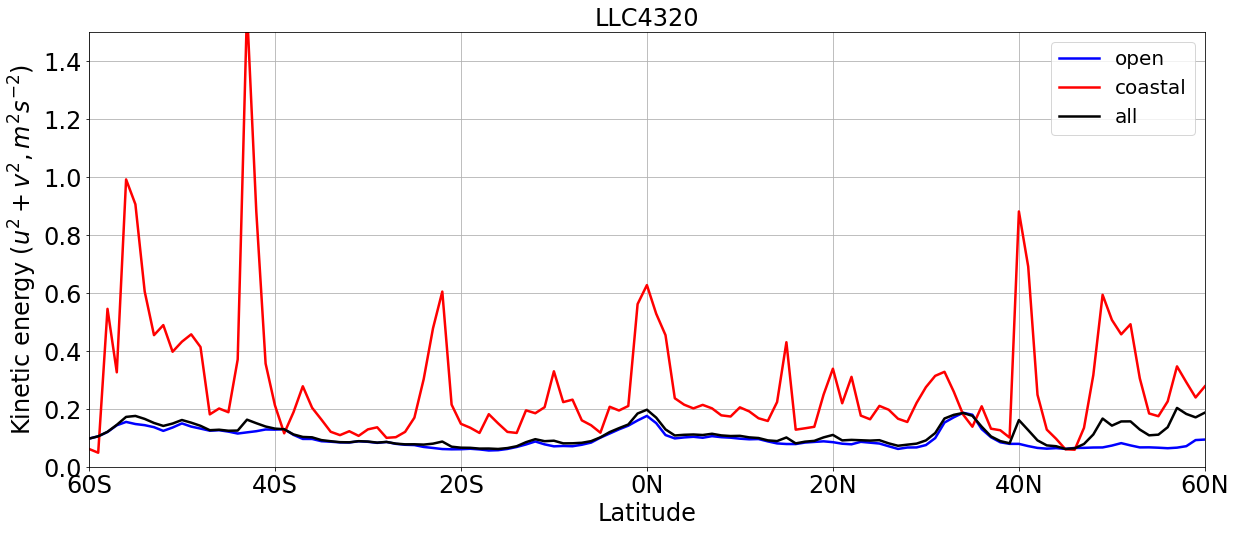

In [32]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['open', 'coastal','all']

KE_LLC_zmean_openocean_1080.plot(color='blue', label=labels[0], linewidth=2.5)
KE_LLC_zmean_coastalocean_1080.plot(color='red', label=labels[1], linewidth=2.5)
KE_LLC_zmean_all_1080.plot(color='black', label=labels[2], linewidth=2.5)
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,1.5])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320',fontsize=24)

Text(0.5,1,'LLC4320')

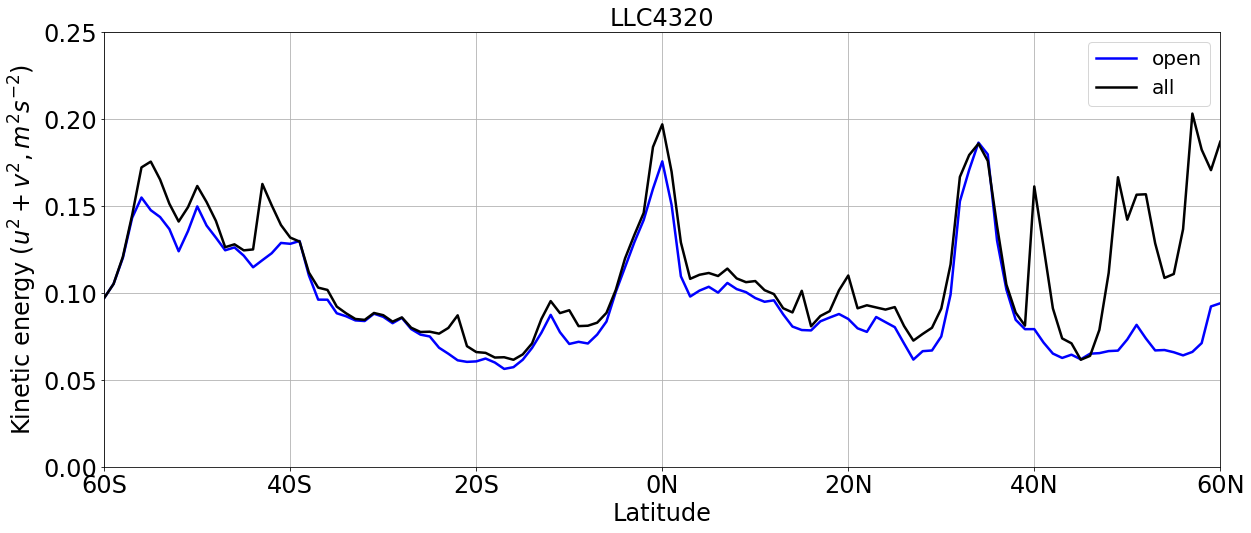

In [50]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['open', 'coastal','all']

KE_LLC_zmean_openocean_1080.plot(color='blue', label=labels[0], linewidth=2.5)
KE_LLC_zmean_all_1080.plot(color='black', label=labels[2], linewidth=2.5)
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.25])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320',fontsize=24)

# 3. Comparison

Text(0.5,1,'Drifters vs LLC4320')

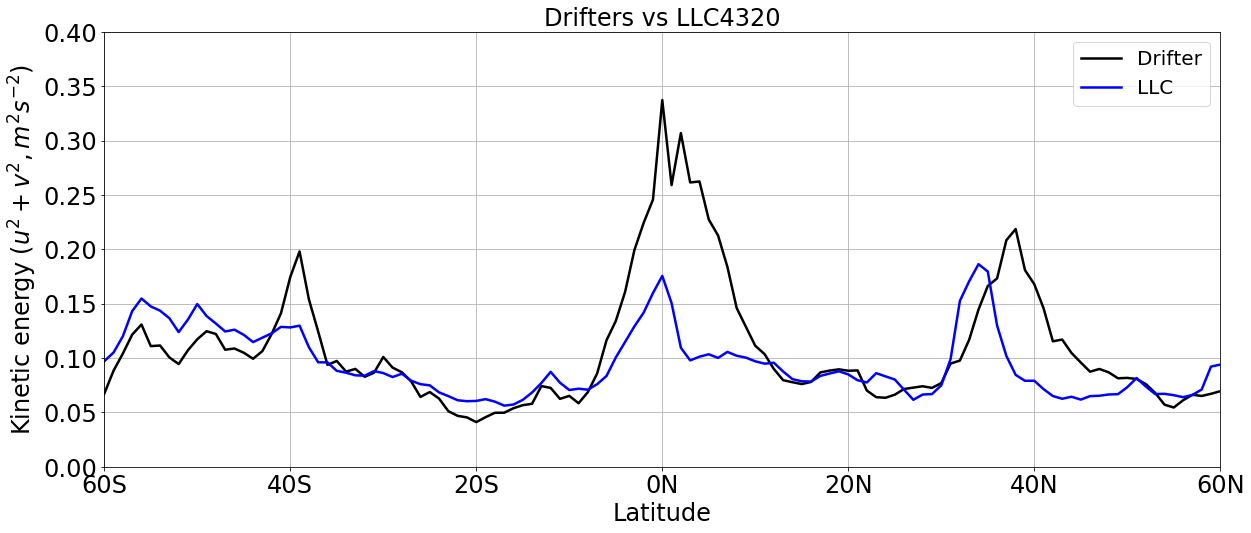

In [49]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Drifter', 'LLC']

#E_drifters_all.plot(color='black', label=labels[0], linewidth=2.5)
E_drifters_qd.plot(color='black', label=labels[0], linewidth=2.5)
#E_drifters_qu.plot(color='black', label=labels[0], linewidth=2.5)

KE_LLC_zmean_openocean_1080.plot(color='blue', label=labels[1], linewidth=2.5)
#KE_LLC_zmean_all_1080.plot(color='blue', label=labels[1], linewidth=2.5)

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters vs LLC4320',fontsize=24)

_________
# method 2 for LLC4320

In [ ]:
subset_factor = 1

ds_subset = (xr.merge([grid.reset_coords()[['XC', 'YC','CS', 'SN']], ds_SSU, ds_SSV])
               .isel(j=slice(0 ,None, subset_factor),
                     i=slice(0, None, subset_factor))
               .stack(point=['face','j', 'i'])
               .chunk({'time': 1440, 'point': 10000})) # chunk it into 30 day segments (60 days not working - killed workers)
print(ds_subset)
print('\n data size: %.1f GB' %(ds_subset.nbytes / 1e9))

In [12]:
KE_LLC = ds_subset.SSU**2 + ds_subset.SSV**2
print(KE_LLC)
print('\n data size: %.1f GB' %(KE_LLC.nbytes / 1e9))

<xarray.DataArray (time: 8640, point: 583200)>
dask.array<shape=(8640, 583200), dtype=float32, chunksize=(1440, 10000)>
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * point    (point) MultiIndex
  - face     (point) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  - j        (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - i        (point) int64 0 16 32 48 64 80 96 112 128 144 160 176 192 208 ...

 data size: 20.2 GB


In [13]:
KE_LLC_zonmean = (KE_LLC.groupby_bins(ds_subset['YC'], np.arange(-61, 62, 1), labels=np.arange(-60, 61, 2))
                    .mean(dim=['time', 'point']))
print(KE_LLC_zonmean)

<xarray.DataArray (YC_bins: 61)>
dask.array<shape=(61,), dtype=float32, chunksize=(2,)>
Coordinates:
  * YC_bins  (YC_bins) int64 -60 -58 -56 -54 -52 -50 -48 -46 -44 -42 -40 -38 ...


In [14]:
print(len(KE_LLC_zonmean.data.dask))
%time KE_LLC_zonmean_p = KE_LLC_zonmean.persist(retries=10)

757706
CPU times: user 1min 5s, sys: 1.62 s, total: 1min 7s
Wall time: 1min 7s


In [15]:
%time E_LLC = KE_LLC_zonmean_p.load() 

CPU times: user 9min 47s, sys: 26.9 s, total: 10min 14s
Wall time: 11min 14s


In [31]:
E_LLC

<xarray.DataArray (YC_bins: 61)>
array([     nan, 0.085418, 0.145883, 0.174891, 0.151214, 0.150927, 0.153977,
       0.129513, 0.125195, 0.150393, 0.135751, 0.127534, 0.103932, 0.09233 ,
       0.084957, 0.087153, 0.084829, 0.081261, 0.077845, 0.080702, 0.072351,
       0.064517, 0.062041, 0.06476 , 0.086646, 0.08919 , 0.083498, 0.083554,
       0.102698, 0.132557, 0.179358, 0.168158, 0.111936, 0.112262, 0.111779,
       0.106016, 0.104028, 0.090716, 0.093936, 0.086568, 0.102274, 0.092865,
       0.091703, 0.090627, 0.075534, 0.080472, 0.119782, 0.177437, 0.172959,
       0.112947, 0.094644, 0.132361, 0.07706 , 0.062446, 0.080999, 0.138249,
       0.152345, 0.126122, 0.117763, 0.184023, 0.182631], dtype=float32)
Coordinates:
  * YC_bins  (YC_bins) int64 -60 -58 -56 -54 -52 -50 -48 -46 -44 -42 -40 -38 ...

In [52]:
cluster.scheduler.close()

<Future finished result=None>